In [0]:
import numpy as np
import math, random
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

np.random.seed(0)

In [0]:

# Generating a clean sine wave
def sine(X, signal_freq=60.):
    return np.sin(2 * np.pi * (X) / signal_freq)

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

# Create a noisy and clean sine wave
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = sine(X + random_offset)
    inp = noisy(out)
    return inp, out

def create_dataset(n_samples=10000, sample_size=100):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))

    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out

[[-0.76519801 -0.83833875 -0.31352613 ...  0.29238948 -0.18993312
   0.14921939]
 [-1.13011457 -0.87458687 -1.18057269 ...  0.75798613  0.84306268
   0.97292112]
 [ 0.70643151  0.98916796  0.96552402 ... -0.73288531 -0.7902406
  -0.59296502]
 ...
 [ 0.05262317  0.37672996 -0.09553931 ... -0.8716361  -0.90649547
  -1.07794768]
 [-0.21276687 -0.50156193 -0.53916548 ... -0.24606463 -0.07693085
  -0.32448498]
 [-1.03760644 -1.16485305 -0.8775262  ...  0.67227487  0.58317958
   0.54242757]]
[[-0.76519801]
 [-0.83833875]
 [-0.31352613]
 ...
 [ 0.67227487]
 [ 0.58317958]
 [ 0.54242757]]
tensor([[-0.7652],
        [-0.8383],
        [-0.3135],
        ...,
        [ 0.6723],
        [ 0.5832],
        [ 0.5424]])
[[ 0.915739    0.6632104   1.2938391  ... -0.40612212 -0.8267818
  -1.090385  ]
 [-0.59331167 -0.9609526  -0.7621772  ... -1.1544547  -0.5983687
  -0.5437468 ]
 [ 1.3113512   0.8433219   1.2245834  ... -1.0473536  -1.0156049
  -0.80887747]
 ...
 [ 0.47321036  0.50750685  1.0198534  ..

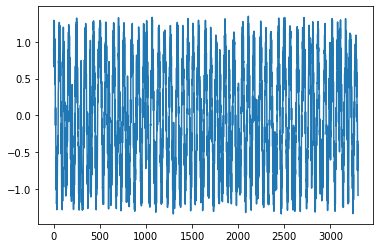

In [0]:
sample_size=100
X, y = create_dataset(sample_size=sample_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train)
print(X_train.reshape((-1, 1)))
print(torch.from_numpy(X_train.reshape((-1, 1))).float())
X_train_torch = torch.from_numpy(X_train.reshape((-1, 1))).float()
y_train_torch = torch.from_numpy(y_train.reshape((-1, 1))).float()
X_test_torch = torch.from_numpy(X_test.reshape((-1, 1))).float()
y_test_torch = torch.from_numpy(y_test.reshape((-1, 1))).float()
print(X_test_torch.data.numpy().reshape(sample_size, -1))
plt.plot(X_test_torch.data.numpy().reshape(sample_size, -1)[0], label='Clear')
# plt.plot(y_test_torch.data.numpy(), label='Noisy')

In [0]:


import torch
import torch.nn as nn
from torch.autograd import Variable


input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r = CustomRNN(input_dim, hidden_size, 1)
print(r)

CustomRNN(
  (rnn): RNN(1, 30, batch_first=True)
  (linear): Linear(in_features=30, out_features=1, bias=True)
  (act): Tanh()
)


In [0]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(301):
    hidden = None
    pred = r(X_train_torch)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, y_train_torch)
    if t%20==0:
        print(t, loss.data)
    loss.backward()
    optimizer.step()

0 tensor(0.7277)
20 tensor(0.1286)
40 tensor(0.1149)
60 tensor(0.1087)
80 tensor(0.0948)
100 tensor(0.0852)
120 tensor(0.0834)
140 tensor(0.0794)
160 tensor(0.0780)
180 tensor(0.0764)
200 tensor(0.0746)
220 tensor(0.0772)
240 tensor(0.0737)
260 tensor(0.0714)
280 tensor(0.0726)
300 tensor(0.0701)


In [0]:
pred = r(X_test_torch)

# Test loss
print(loss_func(pred, y_test_torch).data)

tensor(0.0734)


Text(0.5, 1.0, 'Sample num: 42')

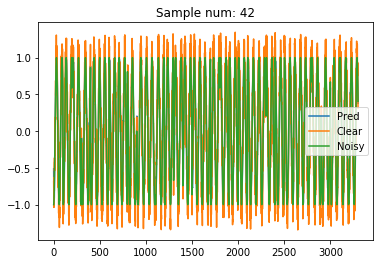

In [0]:
sample_num = 42
plt.plot(pred[sample_num].data.numpy(), label='Pred')
plt.plot(X_test_torch[sample_num].data.numpy(), label='Clear')
plt.plot(y_test_torch[sample_num].data.numpy(), label='Noisy')
plt.legend()
plt.title("Sample num: {}".format(sample_num))